# 감정분류 모델_(언더샘플링 O)

In [1]:
# 필요한 모듈 임포트
import pandas as pd
import tensorflow as tf
from tensorflow.keras import preprocessing
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, Dropout, Conv1D, GlobalMaxPool1D, concatenate
from sklearn.preprocessing import LabelEncoder
import numpy as np

In [2]:
# 데이터 불러오기

train_file = "c:/2nd_project/Data/talk_data/영화주제 대화 말뭉치 라벨링_최종.csv"
data = pd.read_csv(train_file, delimiter=',')
# data = data[data['label'] != 0]
data.head()

,text,label
0,다들 기생충 보셨어요,0
1,오스카 상 후보에 올랐단 소식 듣고 바로 봤어요,0
2,저는 개인적으로 다크한 걸 안 좋아해서 아직 못 봤어요,0
3,음그럴 수 있죠,0
4,봉준호 감독이 차기작을 준비하고 있다고 해서 한 번 그냥 물어봤어요 하하,0


In [3]:
# 데이터 분포 확인

data['label'].value_counts()

label
0    79786
1     1605
6     1590
3     1271
4      256
2      204
Name: count, dtype: int64

In [4]:
# 언더샘플링
train_cols = data.columns[:-1]

X = data[train_cols]
y = data['label']

from imblearn.under_sampling import RandomUnderSampler

X_sample, y_sample = RandomUnderSampler(random_state=0).fit_resample(X, y)
X_samp = pd.DataFrame(data=X_sample,columns=train_cols )
y_samp = pd.DataFrame(data=y_sample,columns=['label'])

data_samp=pd.concat([X_samp,y_samp],axis=1)

data_samp["label"].value_counts()

label
0    204
1    204
2    204
3    204
4    204
6    204
Name: count, dtype: int64

In [5]:
# 문장과 라벨 분류

queries = data_samp['text'].tolist()
intents = data_samp['label'].tolist()

In [6]:
# 전처리

from Preprocess2 import Preprocess2
p = Preprocess2(word2index_dic='c:/2nd_project/Data/[최종] chatbot_dict.bin',
               userdic = 'c:/2nd_project/Data/[최종] user_dic.txt')

In [7]:
# 문장 숫자로 변환

sequences = []
for sentence in queries:
    sentence = str(sentence)
    pos = p.pos(sentence)
    keywords = p.get_keywords(pos, without_tag=True)
    seq = p.get_wordidx_sequence(keywords)
    sequences.append(seq)

In [8]:
sequences

[[447, 1, 1061],
 [3277, 4164, 784, 186, 92, 134, 569],
 [92, 473, 31, 163, 82],
 [128, 11146, 408, 24],
 [4575, 82, 8123, 43329, 610, 313, 82],
 [328, 106, 18],
 [9, 445, 541, 2210, 1273, 3],
 [145, 214, 41, 1219, 91, 3],
 [27, 61, 541, 4957],
 [1819, 214, 327, 3, 3082, 249, 204, 35, 19],
 [145, 82, 187, 364, 92, 53, 4524, 521],
 [12263, 612, 2],
 [328, 6650, 521],
 [61, 3, 2415, 1229, 82],
 [2515, 412, 17101, 1557, 91, 2, 4205, 99, 60, 82],
 [430, 3, 63, 79, 62, 132, 82],
 [143, 31, 18],
 [11693, 1731, 99, 18],
 [820, 31, 18, 122, 18],
 [119],
 [82, 1240, 133, 312, 19, 18],
 [27, 216, 118, 18],
 [214, 119, 59, 18, 60],
 [172, 2047, 266, 4082],
 [27, 186, 3900, 18, 484, 919, 18, 13, 752],
 [13987],
 [27, 334, 3501, 62, 59, 18],
 [9, 109, 243, 3450, 2968, 4194, 204, 158, 181, 51, 62],
 [439, 175, 772, 649, 25],
 [9, 2089, 204, 672, 2],
 [243, 214, 78, 63, 145],
 [51, 740, 59, 18],
 [416, 9726, 452, 158, 1053, 53],
 [3933, 79, 962, 1259, 1945],
 [1772, 31, 143, 3934, 19, 82, 113, 60, 82

In [9]:
# 제로 패딩

from GlobalParams import MAX_SEQ_LEN

padded_seqs = preprocessing.sequence.pad_sequences(sequences, maxlen=MAX_SEQ_LEN, padding='post')

In [10]:
padded_seqs

array([[  447,     1,  1061, ...,     0,     0,     0],
       [ 3277,  4164,   784, ...,     0,     0,     0],
       [   92,   473,    31, ...,     0,     0,     0],
       ...,
       [15256,     0,     0, ...,     0,     0,     0],
       [36924,     0,     0, ...,     0,     0,     0],
       [  170,     1,  1117, ...,  1956,  1096,  7418]])

In [11]:
# X = corpus_df[['text']].astype(str)
X = padded_seqs
y = data_samp['label']

pd.Series(y).value_counts()

label
0    204
1    204
2    204
3    204
4    204
6    204
Name: count, dtype: int64

In [12]:
X.shape

(1224, 15)

In [13]:
print(X)
print('='*40)
print(y)

[[  447     1  1061 ...     0     0     0]
 [ 3277  4164   784 ...     0     0     0]
 [   92   473    31 ...     0     0     0]
 ...
 [15256     0     0 ...     0     0     0]
 [36924     0     0 ...     0     0     0]
 [  170     1  1117 ...  1956  1096  7418]]
17187    0
77226    0
11572    0
68029    0
45580    0
        ..
84051    6
83129    6
83504    6
83861    6
83760    6
Name: label, Length: 1224, dtype: int64


In [14]:
encoder = LabelEncoder()
y_label = encoder.fit_transform(y)
y_label

array([0, 0, 0, ..., 5, 5, 5], dtype=int64)

In [15]:
print(len(y_label))
np.unique(y_label)

1224


array([0, 1, 2, 3, 4, 5], dtype=int64)

In [16]:
# train 데이터와 test 데이터 나누기(8:2)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_label, stratify=y, test_size=0.2, random_state=0)

In [17]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5], dtype=int64)

In [18]:
pd.Series(y_train).value_counts()

5    164
2    163
4    163
3    163
1    163
0    163
Name: count, dtype: int64

In [19]:
# 하이퍼파라미터 설정
dropout_prob = 0.4
EMB_SIZE = 256
EPOCH = 5

VOCAB_SIZE = len(p.word_index) + 1 # 전체 단어수 (패딩 0 포함)

In [20]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(20)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(20)

In [21]:
train_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, 15), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [22]:
# CNN 모델 정의
input_layer = Input(shape=(MAX_SEQ_LEN,))
embedding_layer = Embedding(VOCAB_SIZE, EMB_SIZE, input_length=MAX_SEQ_LEN)(input_layer)
dropout_emb = Dropout(rate = dropout_prob)(embedding_layer)

conv1 = Conv1D(
    filters=128,
    kernel_size=3,
    padding='same',
    activation=tf.nn.relu)(dropout_emb)
pool1 = GlobalMaxPool1D()(conv1)

conv2 = Conv1D(
    filters=128,
    kernel_size=4,
    padding='same',
    activation=tf.nn.relu)(dropout_emb)
pool2 = GlobalMaxPool1D()(conv2)

conv3 = Conv1D(
    filters=128,
    kernel_size=5,
    padding='same',
    activation=tf.nn.relu)(dropout_emb)
pool3 = GlobalMaxPool1D()(conv3)

# 3,4,5gram 이후 합치기
concat = concatenate([pool1, pool2, pool3])

hidden1 = Dense(128, activation=tf.nn.relu)(concat)
hidden2 = Dense(128, activation=tf.nn.relu)(hidden1)
hidden3 = Dense(128, activation=tf.nn.relu)(hidden2)

dropout_hidden = Dropout(rate=dropout_prob)(hidden3)
logits = Dense(6, name='logits')(dropout_hidden)
predictions = Dense(6, activation=tf.nn.softmax)(logits)

# 모델 생성
model = Model(inputs=input_layer, outputs=predictions)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 15)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 15, 256)      24606976    ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 15, 256)      0           ['embedding[0][0]']              
                                                                                                  
 conv1d (Conv1D)                (None, 15, 128)      98432       ['dropout[0][0]']                
                                                                                              

In [23]:
# 모델 학습
hist = model.fit(train_ds, validation_data=test_ds, epochs=EPOCH, verbose=1)

Epoch 1/5
49/49 [==============================] - 5s 54ms/step - loss: 1.5168 - accuracy: 0.3596 - val_loss: 1.1102 - val_accuracy: 0.5592
Epoch 2/5
49/49 [==============================] - 2s 44ms/step - loss: 0.7977 - accuracy: 0.7181 - val_loss: 0.3737 - val_accuracy: 0.9020
Epoch 3/5
49/49 [==============================] - 2s 49ms/step - loss: 0.3004 - accuracy: 0.9234 - val_loss: 0.2378 - val_accuracy: 0.9265
Epoch 4/5
49/49 [==============================] - 2s 44ms/step - loss: 0.1299 - accuracy: 0.9683 - val_loss: 0.2119 - val_accuracy: 0.9184
Epoch 5/5
49/49 [==============================] - 2s 48ms/step - loss: 0.0535 - accuracy: 0.9877 - val_loss: 0.2432 - val_accuracy: 0.9347


In [24]:
# model.save(f'c:/2nd_project/Model/intent_model/intent_uso_model_0828_e2_ep({EPOCH})_b.h5')

### 평가

##### 1) Accuracy / Loss

In [25]:
import tensorflow as tf

model = tf.keras.models.load_model('c:/2nd_project/Model/intent_model/intent_uso_model_0828_e2_ep(5).h5')
# 모델 평가
score = model.evaluate(X_test, y_test, verbose=1)
print(f"EPOCH : {EPOCH}")
print(f"Accuracy: {round(score[1],4)}")
print(f"Loss: {round(score[0],4)}")

8/8 [==============================] - 0s 18ms/step - loss: 0.1652 - accuracy: 0.9429
EPOCH : 5
Accuracy: 0.9429
Loss: 0.1652


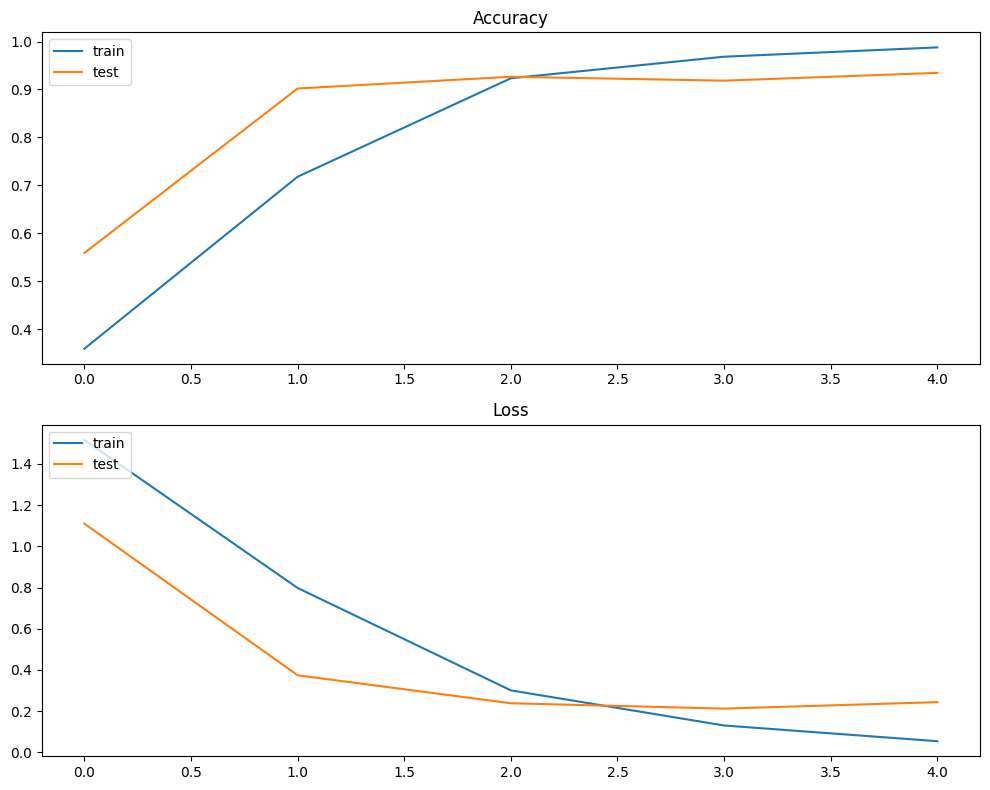

In [26]:
import matplotlib.pyplot as plt


# 그래프 크기 조정
plt.figure(figsize=(10, 8))

# Accuracy 그래프
plt.subplot(2, 1, 1)  # 2행 1열의 첫 번째 subplot
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

# Loss 그래프
plt.subplot(2, 1, 2)  # 2행 1열의 두 번째 subplot
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Loss')
plt.legend(['train', 'test'], loc='upper left')

# 그래프 간격 조정
plt.tight_layout()

# 그래프 표시
plt.show()

### TEST

In [27]:
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import preprocessing

# 의도 분류 모델 모듈
class StoryModel:
    def __init__(self, model_name, proprocess):
        # intent 레이블
        # self.labels = dict(zip(range(0,12),encoder.classes_.tolist()))
        self.labels = {0: '기타',
                        1: '추천',
                        2: '후기',
                        3: '정보',
                        4: '예매',
                        5: '욕설',
                        }
        # intent 분류 모델 불러오기
        self.model = load_model(model_name)
        # 챗봇 Preprocess 객체
        self.p = proprocess

    # 의도 클래스 예측
    def predict_class(self, query):
        # 형태소 분석
        pos = self.p.pos(query)

        # 문장내 키워드 추출(불용어 제거)
        keywords = self.p.get_keywords(pos, without_tag=True)
        sequences = [self.p.get_wordidx_sequence(keywords)]

        # 패딩처리
        padded_seqs = preprocessing.sequence.pad_sequences(sequences, maxlen=MAX_SEQ_LEN, padding='post')
        predict = self.model.predict(padded_seqs)
        predict_class = tf.math.argmax(predict, axis=1)

        return predict_class.numpy()[0]

In [28]:
from GlobalParams import MAX_SEQ_LEN
from Preprocess2 import Preprocess2
p = Preprocess2(word2index_dic='c:/2nd_project/Data/[최종] chatbot_dict.bin',
               userdic = 'c:/2nd_project/Data/[최종] user_dic.txt')

intent = StoryModel(model_name='c:/2nd_project/Model/intent_model/intent_uso_model_0828_e2_ep(5).h5', proprocess=p)

items=["추천해봐라", '추천좀', '추천요', '추천바람', '후기좀', '정보좀', '줄거리 뭐야', '줄거리 뭔데', '줄거리', '줄거리가 어떻게 돼', '내용좀', '내용이 뭐야', '예약', '예매']

for item in items:
    predict = intent.predict_class(item)
    predict_label = intent.labels[predict]

    print(item)
    print("의도 예측 클래스 : ", predict)
    print("의도 예측 레이블 : ", predict_label)

1/1 [==============================] - 0s 157ms/step
추천해봐라
의도 예측 클래스 :  1
의도 예측 레이블 :  추천
1/1 [==============================] - 0s 18ms/step
추천좀
의도 예측 클래스 :  1
의도 예측 레이블 :  추천
1/1 [==============================] - 0s 19ms/step
추천요
의도 예측 클래스 :  1
의도 예측 레이블 :  추천
1/1 [==============================] - 0s 19ms/step
추천바람
의도 예측 클래스 :  1
의도 예측 레이블 :  추천
1/1 [==============================] - 0s 19ms/step
후기좀
의도 예측 클래스 :  2
의도 예측 레이블 :  후기
1/1 [==============================] - 0s 18ms/step
정보좀
의도 예측 클래스 :  3
의도 예측 레이블 :  정보
1/1 [==============================] - 0s 18ms/step
줄거리 뭐야
의도 예측 클래스 :  3
의도 예측 레이블 :  정보
1/1 [==============================] - 0s 18ms/step
줄거리 뭔데
의도 예측 클래스 :  3
의도 예측 레이블 :  정보
1/1 [==============================] - 0s 18ms/step
줄거리
의도 예측 클래스 :  3
의도 예측 레이블 :  정보
1/1 [==============================] - 0s 18ms/step
줄거리가 어떻게 돼
의도 예측 클래스 :  3
의도 예측 레이블 :  정보
1/1 [==============================] - 0s 20ms/step
내용좀
의도 예측 클래스 :  3
의도 예측 레이블 :  정보
1/1 [=====================